![image.png](attachment:image.png)

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [43]:
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

df = pd.read_feather('/content/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [44]:
df['data_ref'].unique()

<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00',
 '2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 15, dtype: datetime64[ns]

In [45]:
oot = df[df['data_ref'].dt.year == 2016]
oot.drop(columns=['data_ref', 'index'], inplace=True)

<ipython-input-45-58c32419d673>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot.drop(columns=['data_ref', 'index'], inplace=True)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [46]:
df['data_ref'].groupby(df['data_ref'].dt.to_period("M")).count()

data_ref
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: data_ref, dtype: int64

In [47]:
df.drop(columns=['data_ref', 'index'], inplace=True)
qualitativas = df.select_dtypes(include=['object', 'bool'])
quantitativas = df.select_dtypes(include=['int64', 'float64'])

In [48]:
qualitativas.describe()

,sexo,posse_de_veiculo,posse_de_imovel,tipo_renda,educacao,estado_civil,tipo_residencia,mau
count,750000,750000,750000,750000,750000,750000,750000,750000
unique,2,2,2,5,5,5,6,2
top,F,N,S,Assalariado,Médio,Casado,Casa,False
freq,504580,457954,503692,385740,506836,526472,674294,691357


In [49]:
quantitativas.describe()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,750000.000000,750000.000000,624043.000000,750000.000000,7.500000e+05
mean,0.433251,43.804733,7.748574,2.212241,2.323854e+04
std,0.739379,11.229868,6.687455,0.903428,7.910601e+04
min,0.000000,22.000000,0.117808,1.000000,1.076700e+02
25%,0.000000,34.000000,3.049315,2.000000,3.467700e+03
50%,0.000000,43.000000,6.046575,2.000000,7.861820e+03
75%,1.000000,53.000000,10.183562,3.000000,1.831828e+04
max,14.000000,68.000000,42.906849,15.000000,4.083986e+06


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [50]:
for i, c1 in enumerate(qualitativas.columns):
  for c2 in qualitativas.columns[i+1:]:
    biv = pd.crosstab(df[c1], df[c2])
    chi2, p, dof, ex = chi2_contingency(biv)

    print(f"\nTabela cruzada entre {c1} e {c2}:")
    print(f"Chi-square test: chi2={chi2}, p-value={p}")


Tabela cruzada entre sexo e posse_de_veiculo:
Chi-square test: chi2=100870.0291516938, p-value=0.0

Tabela cruzada entre sexo e posse_de_imovel:
Chi-square test: chi2=2247.527514858336, p-value=0.0

Tabela cruzada entre sexo e tipo_renda:
Chi-square test: chi2=27113.00580105838, p-value=0.0

Tabela cruzada entre sexo e educacao:
Chi-square test: chi2=384.9910277454786, p-value=4.863304187399432e-82

Tabela cruzada entre sexo e estado_civil:
Chi-square test: chi2=21786.607684070288, p-value=0.0

Tabela cruzada entre sexo e tipo_residencia:
Chi-square test: chi2=6928.579347657816, p-value=0.0

Tabela cruzada entre sexo e mau:
Chi-square test: chi2=116.21959444110506, p-value=4.2547733301804896e-27

Tabela cruzada entre posse_de_veiculo e posse_de_imovel:
Chi-square test: chi2=483.2102844969865, p-value=4.277575986479031e-107

Tabela cruzada entre posse_de_veiculo e tipo_renda:
Chi-square test: chi2=17561.783634048443, p-value=0.0

Tabela cruzada entre posse_de_veiculo e educacao:
Chi-sq

In [51]:
corr = quantitativas.corr()

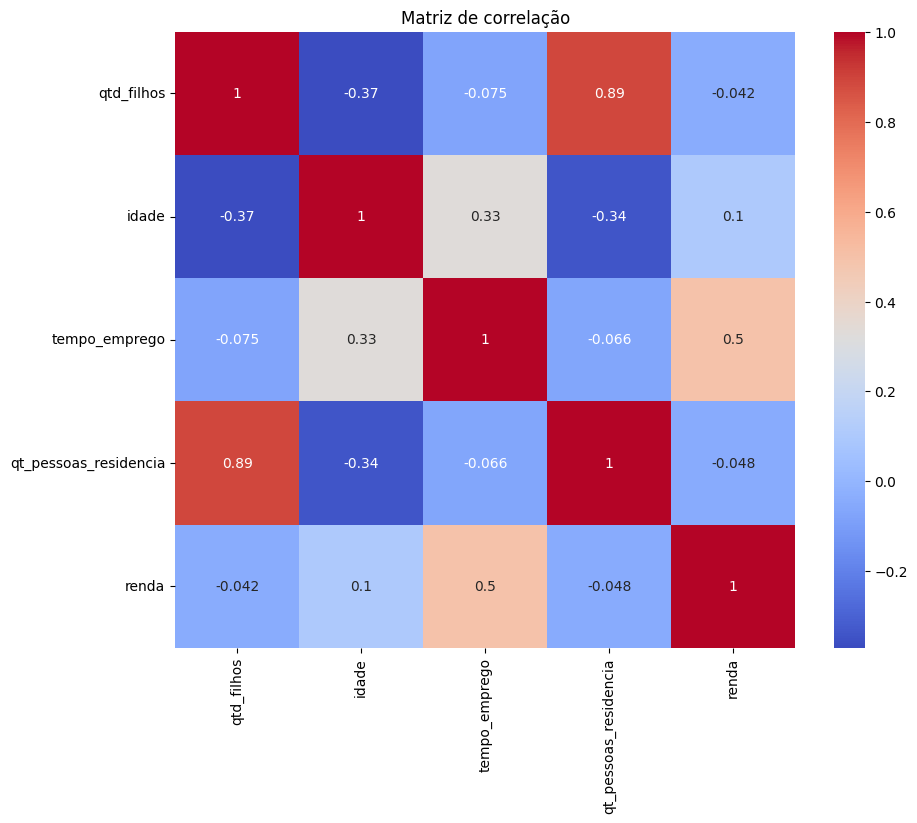

In [52]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlação")
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [53]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [54]:
df.isna().sum()

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [55]:
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)

In [56]:
for column in quantitativas:
  df = remove_outliers(df, column)

In [57]:
qualitativas.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia', 'mau'],
      dtype='object')

In [58]:
df['estado_civil'].value_counts()

estado_civil
Casado      436971
Solteiro     77529
União        48739
Separado     34696
Viúvo        27198
Name: count, dtype: int64

In [59]:
df['tipo_renda'].value_counts()

tipo_renda
Assalariado         314031
Empresário          144933
Pensionista         120180
Servidor público     45691
Bolsista               298
Name: count, dtype: int64

In [60]:
df['educacao'] = df['educacao'].replace(['Superior completo', 'Superior incompleto', 'Pós graduação'], 'Alta Escolaridade')
df['educacao'] = df['educacao'].replace(['Médio', 'Fundamental'], 'Baixa Escolaridade')

df['tipo_renda'] = df['tipo_renda'].replace(['Assalariado', 'Servidor público'], 'Assalariado')

df['estado_civil'] = df['estado_civil'].replace(['Viúvo', 'Separado', 'Solteiro'], 'Solteiro')
df['estado_civil'] = df['estado_civil'].replace(['Casado', 'União'], 'Compromissado')

In [61]:
df['mau'] = df['mau'].astype(int)

In [62]:
df['mau'].value_counts()

mau
0    568414
1     56719
Name: count, dtype: int64

# Desenvolver o Modelo

In [63]:
df = pd.get_dummies(df)

In [64]:
X = df.drop(columns=['mau'])
y = df['mau']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [67]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [68]:
coefficients = pd.DataFrame({'Variable': X_train.columns, 'Coefficient': model.coef_[0]})
coefficients.sort_values(by='Coefficient', ascending=False)

,Variable,Coefficient
14,tipo_renda_Pensionista,0.071480
0,qtd_filhos,0.051904
23,tipo_residencia_Estúdio,0.000357
24,tipo_residencia_Governamental,0.000300
12,tipo_renda_Bolsista,0.000048
4,renda,-0.000178
17,estado_civil_Compromissado,-0.002358
22,tipo_residencia_Comunitário,-0.002744
19,tipo_residencia_Aluguel,-0.006099
1,idade,-0.007824


Categorias que têm coeficientes muito próximos de zero ou que não contribuem significativamente para o modelo podem ser removidas.

Equação preditiva:

$$
\text{logit}(p) = \beta_0 + \sum_{i=1}^{n} \beta_i X_i
$$

Onde:

logit(p) é o logaritmo da razão de chances de
𝑝
p (a probabilidade de inadimplência).
𝛽
0
β
0
​
  é o intercepto.
𝛽
𝑖
β
i
​
  são os coeficientes das variáveis explicativas
𝑋
𝑖
X
i
​
 .

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [69]:
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))

In [70]:
print("Acurácia nos dados de treino:", train_accuracy)
print("Acurácia nos dados de teste:", test_accuracy)

Acurácia nos dados de treino: 0.9091164621006278
Acurácia nos dados de teste: 0.9096246134158046


In [71]:
y_test[y_test==1]

673862    1
658359    1
272585    1
637990    1
749176    1
         ..
563931    1
180629    1
718232    1
623972    1
50991     1
Name: mau, Length: 16949, dtype: int64

In [72]:
k2_test, _ = ks_2samp(y_test==1, y_test==0)
k2_train, _ = ks_2samp(y_train==1, y_train==1)

In [73]:
print("K2 nos dados de treino:", k2_test)
print("K2 nos dados de teste:", k2_train)

K2 nos dados de treino: 0.8192492268316092
K2 nos dados de teste: 0.0


In [74]:
def gini_score(y_true, y_pred_prob):
    auc = roc_auc_score(y_true, y_pred_prob)
    return 2 * auc - 1

In [75]:
train_gini = gini_score(y_train, model.predict_proba(X_train)[:, 1])
test_gini = gini_score(y_test, y_pred_prob)

In [76]:
print("Gini nos dados de treino:", train_gini)
print("Gini nos dados de teste:", test_gini)

Gini nos dados de treino: 0.4942977074781296
Gini nos dados de teste: 0.5025729557409702
